In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import random
from torchvision import datasets, transforms
from PIL import Image  
import os 

import torch.nn as nn
from transformers import AdamW  
from tqdm.auto import tqdm
from transformers import MobileNetV2Config, MobileNetV2ForImageClassification

from datasets import DatasetDict, load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
import evaluate
from transformers import TrainingArguments, Trainer
from transformers import DefaultDataCollator
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

In [44]:
data_dir = './PlantDoc-Dataset' 
batch_size = 64
num_workers = 2  

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),
}

class PlantDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_paths = self.load_image_paths()
        label_set = set()  # Track unique labels
        path = root_dir + '/' + split
        for label in os.listdir(path):
            label_set.add(label)
        self.num_labels = len(label_set) 

    def load_image_paths(self):
        image_paths = []
        data_path = os.path.join(self.root_dir, self.split)
        for label_idx, label in enumerate(os.listdir(data_path)):
            label_path = os.path.join(data_path, label)
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                image_paths.append((image_path, label, label_idx))
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, label, label_idx = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  
        if self.transform:
            image = self.transform(image)

        return image, label, label_idx  

train_dataset = PlantDataset(data_dir, split='train', transform=data_transforms['train'])
test_dataset = PlantDataset(data_dir, split='test', transform=data_transforms['test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [71]:
id2label = {i: label for i, label in enumerate(os.listdir('./PlantDoc-Dataset/train'))}
label2id = {label: i for i, label in id2label.items()}
id2label[1]

'Apple Scab Leaf'

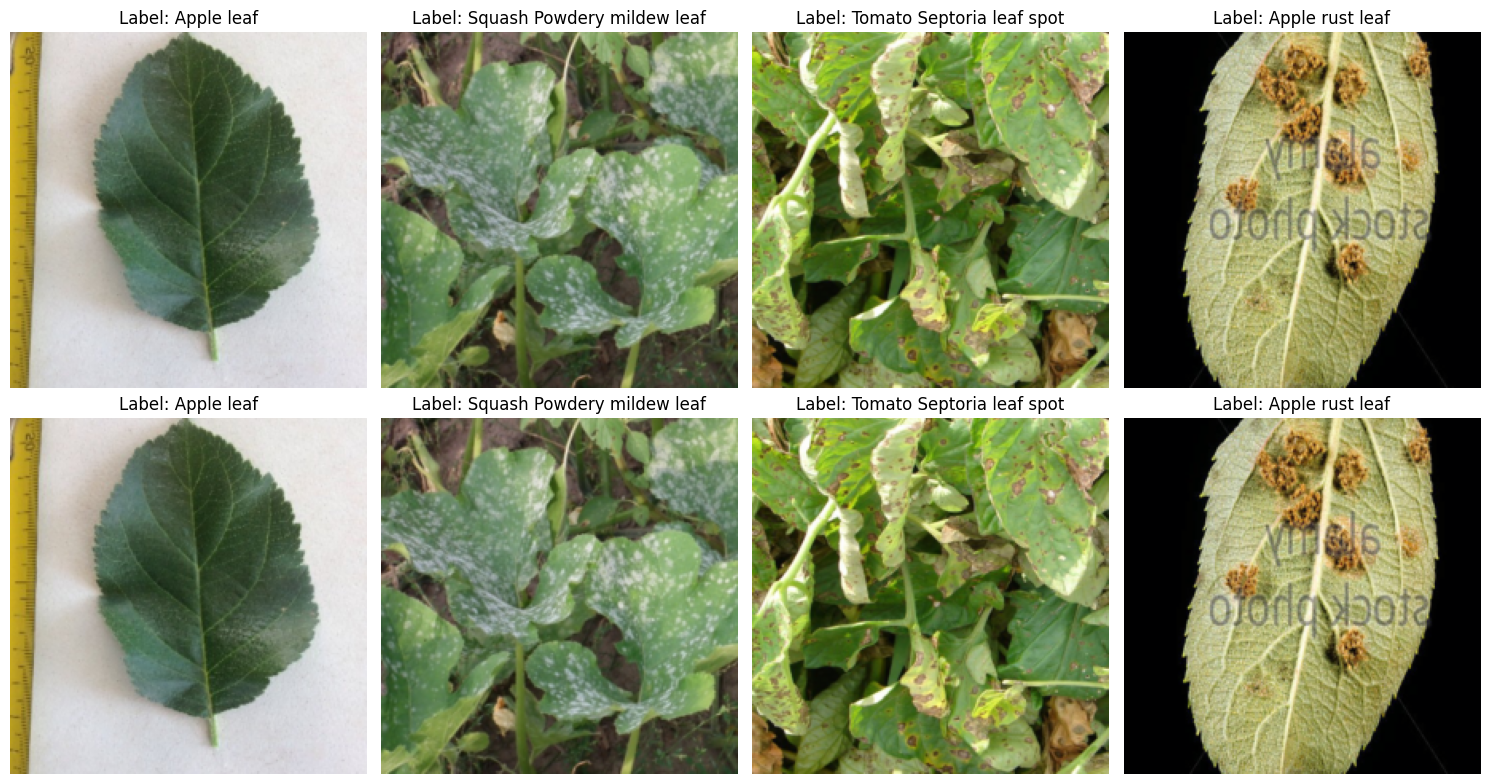

In [45]:
num_images_per_label = 4
figsize = (15, 8) 

def display_images(data_loader, num_images_per_label):
    labels_seen = set()
    fig, axes = plt.subplots(nrows=2, ncols=num_images_per_label, figsize=figsize)

    for images, labels, _ in data_loader:
        for image, label in zip(images, labels):
            if label not in labels_seen:
                labels_seen.add(label)  

                for row in axes:
                    for ax in row:
                        if not ax.has_data():
                            image_disp = image.numpy().transpose((1, 2, 0))
                            mean = np.array([0.485, 0.456, 0.406])
                            std = np.array([0.229, 0.224, 0.225])
                            image_disp = std * image_disp + mean
                            image_disp = np.clip(image_disp, 0, 1) 

                            ax.imshow(image_disp)
                            ax.set_title(f"Label: {label}")
                            ax.axis('off')
                            break 

            if len(labels_seen) == num_images_per_label * 2:
                return 

display_images(train_loader, num_images_per_label) 
plt.tight_layout()
plt.show()


## MobileNet-V2 Training

In [46]:
num_labels = train_dataset.num_labels
print(f"Number of labels: {num_labels}")

student_config = MobileNetV2Config(num_labels=num_labels)
student_model = MobileNetV2ForImageClassification(student_config)
student_model.classifier = nn.Identity() 
student_model.classifier = nn.Linear(1280, num_labels)  
pretrained_dict = torch.load('./distilled-vit-beans/student_model.pth')
model_dict = student_model.state_dict()

pretrained_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith('classifier')}

model_dict.update(pretrained_dict) 
student_model.load_state_dict(model_dict) 

Number of labels: 28


<All keys matched successfully>

In [ ]:
epochs = 100
learning_rate = 1e-5 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

student_model.to(device) 

loss_function = nn.CrossEntropyLoss()
optimizer = AdamW(student_model.parameters(), lr=learning_rate)

def evaluate(model, data_loader, device):
    model.eval()  
    num_correct = 0
    num_samples = 0
    with torch.no_grad():  
        for data in data_loader:
            images, labels = data[0].to(device), data[2].to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs.logits, 1)  
            num_correct += (predictions == labels).sum().item()
            num_samples += labels.shape[0]

    accuracy = num_correct / num_samples
    print(f'Validation Accuracy: {accuracy:.4f}')
    model.train()  

for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for i, data in enumerate(train_loader): 
        images, labels = data[0].to(device), data[2].to(device) 

        optimizer.zero_grad()

        outputs = student_model(images)
        loss = loss_function(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  
            print(f'Epoch {epoch+1}, Batch {i+1}: loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    print("-" * 50)  
    with torch.cuda.amp.autocast() if torch.cuda.is_available() else torch.no_grad():
        evaluate(student_model, test_loader, device)  

print('Training finished!')

## DEiT-Model Training

In [1]:
data_dir = "./PlantDoc-Dataset"

dataset = load_dataset("imagefolder", data_dir=data_dir)

dataset_dict = DatasetDict({
    "train": dataset["train"],
    "test": dataset["test"]
})

dataset_dict

Resolving data files:   0%|          | 0/2342 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/236 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2342
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 236
    })
})

In [61]:
id2label = {i: label for i, label in enumerate(os.listdir('./PlantDoc-Dataset/train'))}
label2id = {label: i for i, label in id2label.items()}
num_labels = len(id2label)

In [62]:
model_name = "./plant-disease-severity/checkpoint-166" 
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

In [5]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (224, 224)
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [6]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [7]:
dataset_dict = dataset_dict.with_transform(transforms)

In [8]:
accuracy = evaluate.load("accuracy")

In [9]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [10]:
data_collator = DefaultDataCollator()

training_args = TrainingArguments(
    output_dir="plant-disease-severity",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to=None
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: Currently logged in as: smartpy (justalearner). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
0,3.398700,3.078985,0.177966
2,1.435600,1.524928,0.525424
4,0.665200,1.137703,0.614407
6,0.453400,0.964443,0.661017
8,0.333100,1.019603,0.656780
10,0.257200,0.942793,0.716102
12,0.204800,0.915868,0.682203


Checkpoint destination directory plant-disease-severity/checkpoint-37 already exists and is non-empty. Saving will proceed but saved results may be invalid.


KeyboardInterrupt: 

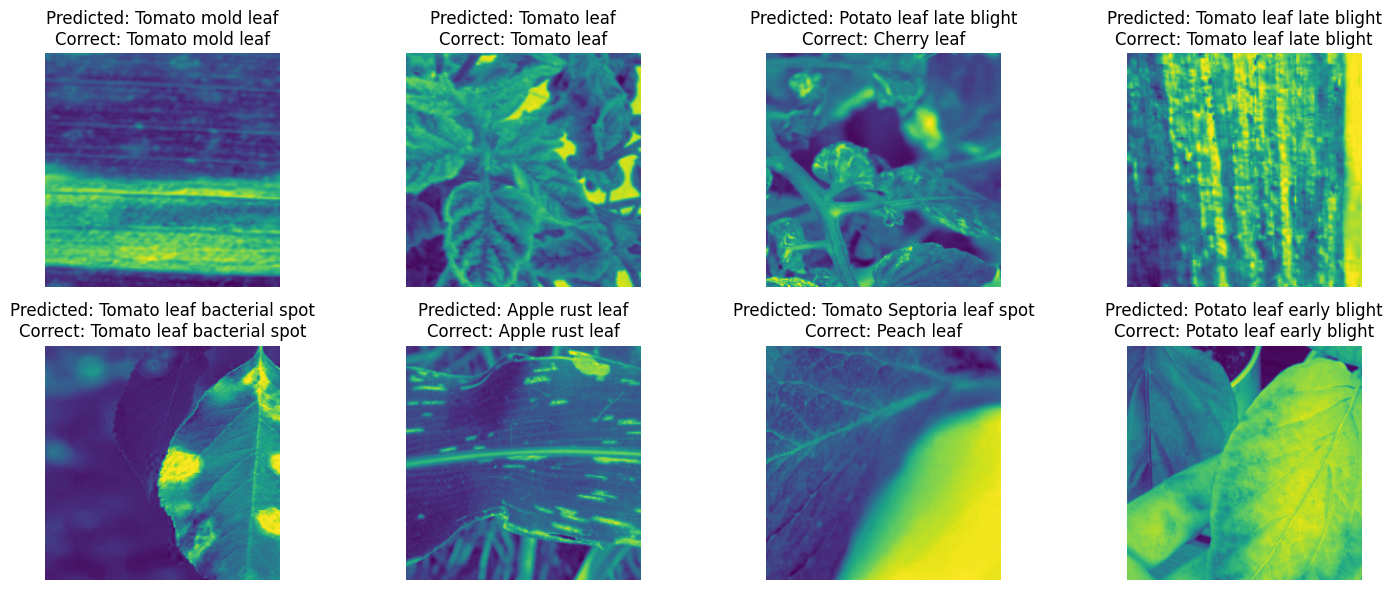

In [58]:
def show_images_in_grid(images, labels, columns=4):

    rows = (len(images) + columns - 1) // columns 
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 3 * rows))

    for idx, (image, label) in enumerate(zip(images, labels)):
        row = idx // columns
        col = idx % columns
        ax = axes[row, col] if rows > 1 else axes[col]  
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def predict_on_random_images(model, image_processor, dataset, id2label, num_images=8):
    random_indices = random.sample(range(len(dataset)), num_images)
    images = []  
    labels = [] 

    for idx in random_indices:
        inputs = dataset[idx]
        label = inputs['label']
        inputs = {k: v.to('cuda') for k, v in inputs.items() if k != 'label'}

        with torch.no_grad():
            outputs = model(pixel_values=inputs['pixel_values'].unsqueeze(0))
            logits = outputs.logits

        predicted_class_idx = logits.argmax(-1).item()
        predicted_label = id2label[predicted_class_idx]

        image_array = inputs['pixel_values'].cpu().numpy()[0]  
        if image_array.shape[0] == 3:  
            image_array = np.transpose(image_array, (1, 2, 0)) 

        images.append(image_array)
        predicted_color = 'green' if predicted_label == id2label[label] else 'red'
        correct_color = 'green' if predicted_label == id2label[label] else 'black'  
        labels.append(f"Predicted: {predicted_label}\nCorrect: {id2label[label]}") 

    show_images_in_grid(images, labels)

predict_on_random_images(model, image_processor, dataset_dict['test'], id2label)

In [48]:
id2label = {i: label for i, label in enumerate(os.listdir('./PlantDoc-Dataset/test'))}
label2id = {label: i for i, label in id2label.items()}
num_labels = len(id2label)

In [49]:
def evaluate_model(model, image_processor, eval_dataset, id2label):

  predictions = []
  true_labels = []

  for datapoint in eval_dataset:
      labels = datapoint['label']
      datapoint = {k:v.to('cuda') for k, v in datapoint.items() if k!='label'}
      
      with torch.no_grad():
          outputs = model(pixel_values=datapoint['pixel_values'].unsqueeze(0))
          logits = outputs.logits

      predicted_class_idx = logits.argmax(-1).item()
      predictions.append(predicted_class_idx)
      true_labels.append(labels) 

  f1_score_macro = f1_score(true_labels, predictions, average='macro')
  f1_score_weighted = f1_score(true_labels, predictions, average='weighted')
  f1_per_class = f1_score(true_labels, predictions, average=None)  

  report = classification_report(true_labels, predictions, target_names=list(id2label.values()))

  return {
      "f1_score_macro": f1_score_macro,
      "f1_score_weighted": f1_score_weighted,
      "f1_per_class": dict(zip(id2label.keys(), f1_per_class)),
      "classification_report": report
  }

results = evaluate_model(model, image_processor, dataset_dict['test'], id2label)
print(f"F1 Score (Macro): {results['f1_score_macro']}")
print(f"F1 Score (Weighted): {results['f1_score_weighted']}")
print(results["classification_report"])

F1 Score (Macro): 0.677650804423873
F1 Score (Weighted): 0.6821161432402346
                            precision    recall  f1-score   support

  Tomato leaf mosaic virus       1.00      1.00      1.00        10
           Apple Scab Leaf       0.54      0.78      0.64         9
Tomato leaf bacterial spot       1.00      0.80      0.89        10
  Potato leaf early blight       0.70      0.88      0.78         8
          Bell_pepper leaf       0.83      0.56      0.67         9
  Tomato leaf yellow virus       0.62      0.73      0.67        11
Squash Powdery mildew leaf       0.83      0.50      0.62        10
          Tomato mold leaf       0.30      0.75      0.43         4
           Apple rust leaf       0.86      0.50      0.63        12
   Tomato leaf late blight       1.00      0.90      0.95        10
  Tomato Early blight leaf       0.70      0.78      0.74         9
          Corn leaf blight       0.43      0.38      0.40         8
                Peach leaf       0.38  